In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [7]:
iris = datasets.load_iris()
X = iris.data[50:,[1,2]]
y = iris.target[50:]
print(X[:5])
print(y[-5:])

[[3.2 4.7]
 [3.2 4.5]
 [3.1 4.9]
 [2.3 4. ]
 [2.8 4.6]]
[2 2 2 2 2]


In [9]:
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)
print(y_train[-5:])

[0 1 0 0 0]


# Individual Classifiers

In [10]:
clf1 = LogisticRegression(penalty='l2', C=0.001, solver='lbfgs', random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

In [11]:
print('Cross Validation 10 blocks')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print(' ROC_AUC: %0.2f (+/-%0.2f) [%s]' % (scores.mean(), scores.std(), label))

Cross Validation 10 blocks
 ROC_AUC: 0.92 (+/-0.15) [Logistic Regression]
 ROC_AUC: 0.87 (+/-0.18) [Decision Tree]
 ROC_AUC: 0.85 (+/-0.13) [KNN]


# Ensemble

In [29]:
from sklearn.ensemble import VotingClassifier
v_clf = VotingClassifier(estimators=[('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')
clf_labels.append('Majority Voting')
all_clf = [pipe1, clf2, pipe3, v_clf]

In [30]:
print('Cross Validation 10 blocks')
for clf, label in zip(all_clf, clf_labels):
  scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print(' ROC_AUC: %0.2f (+/-%0.2f) [%s]' % (scores.mean(), scores.std(), label))

Cross Validation 10 blocks
 ROC_AUC: 0.92 (+/-0.15) [Logistic Regression]
 ROC_AUC: 0.87 (+/-0.18) [Decision Tree]
 ROC_AUC: 0.85 (+/-0.13) [KNN]
 ROC_AUC: 0.98 (+/-0.05) [Majority Voting]


# Estimate


In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

Text(0, 0.5, 'True Positive (tpr)')

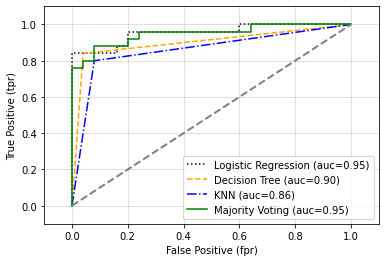

In [36]:
for clf, label, clr, lstyle in zip(all_clf, clf_labels, colors, linestyles):
  y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)
  plt.plot(fpr, tpr, color=clr, linestyle=lstyle, label='%s (auc=%0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], color='grey', linestyle='--', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False Positive (fpr)')
plt.ylabel('True Positive (tpr)')

# GridSearchCV

In [37]:
v_clf.get_params()

{'dt': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                        max_depth=1, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=0, splitter='best'),
 'dt__ccp_alpha': 0.0,
 'dt__class_weight': None,
 'dt__criterion': 'entropy',
 'dt__max_depth': 1,
 'dt__max_features': None,
 'dt__max_leaf_nodes': None,
 'dt__min_impurity_decrease': 0.0,
 'dt__min_impurity_split': None,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 2,
 'dt__min_weight_fraction_leaf': 0.0,
 'dt__presort': 'deprecated',
 'dt__random_state': 0,
 'dt__splitter': 'best',
 'estimators': [('lr', Pipeline(memory=None,
            steps=[('sc',
                    StandardScaler(copy=True, with_mean=True, with_std=True)),
               

In [39]:
from sklearn.model_selection import GridSearchCV
params = {'dt__max_depth': [1,2], 'lr__clf__C': [0.001, 0.1, 100]}
grid = GridSearchCV(estimator=v_clf, param_grid = params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=VotingClassifier(estimators=[('lr',
                                                     Pipeline(memory=None,
                                                              steps=[('sc',
                                                                      StandardScaler(copy=True,
                                                                                     with_mean=True,
                                                                                     with_std=True)),
                                                                     ['clf',
                                                                      LogisticRegression(C=0.001,
                                                                                         class_weight=None,
                                                                                         dual=False,
                                                                      

In [41]:
for r, i in enumerate(grid.cv_results_['mean_test_score']):
  print('%0.3f +/- %0.2f %r' % (grid.cv_results_['mean_test_score'][r], 
                                grid.cv_results_['std_test_score'][r]/2.0, 
                                grid.cv_results_['params'][r]))

0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 1, 'lr__clf__C': 100}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.983 +/- 0.02 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.967 +/- 0.05 {'dt__max_depth': 2, 'lr__clf__C': 100}


In [42]:
print('Best Parameters: %s' % (grid.best_params_))

Best Parameters: {'dt__max_depth': 1, 'lr__clf__C': 0.001}


In [43]:
print('Accuracy: %0.2f' % (grid.best_score_))

Accuracy: 0.98
